# Preamble

In [1]:
%matplotlib widget

# Outer TP Hamiltonian

In [2]:

import os
import sympy as sm
import scipy as sp
import numpy as np
import matplotlib as mpl
import matplotlib.ticker as ticker

from matplotlib import pyplot as plt
from mpl_styles import analytic

from sympy import init_printing

plt.style.use(analytic)
init_printing()

%run "symbols.ipynb"


IPython console for SymPy 1.12 (Python 3.12.0-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.12/



<>:5: SyntaxWarning: invalid escape sequence '\,'
/var/folders/rv/30_ngz5x5l5djjdvflk_6wwm0000gn/T/ipykernel_91120/1608348942.py:5: SyntaxWarning: invalid escape sequence '\,'
  "f_1 f_2 f_3 f_4 tau lambda varpi varpi_p gamma \\omega_{\\rm{ext}} \\omega_{\\rm{p\,ext}} theta Theta phi"


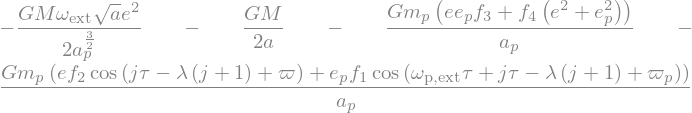

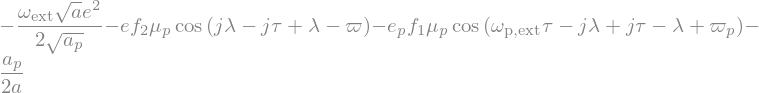

In [3]:

H_scale_factor = Gconst * M / a_p
t_scale_factor = sqrt(Gconst * M / a_p**3)  # = n_p
L_scale_factor = H_scale_factor / t_scale_factor

calH = (
    -(Gconst * M) / (2 * a)
    - Gconst
    * m_p
    / a_p
    * (
        e * f2 * sm.cos((j + 1) * l - j * tau - pom)
        + e_p * f1 * sm.cos((j + 1) * l - j * tau - pom_p - om_p * tau)
    )
    - (Gconst * m_p / a_p * (f3 * e * e_p + f4 * (e**2 + e_p**2)))
    - Rational(1, 2) * sqrt(Gconst * M * a) * e**2 * om * t_scale_factor
)


display(calH)
calH = (
    (calH / H_scale_factor)
    .subs(m_p, mu_p * M)
    .simplify()
    .expand()
    .subs({f3: 0, f4: 0})
    #.subs(a, a * a_p)
)
display(calH)

# Canonical variables and canonical transformations

In [4]:
def is_solve_multiple(sol):
    if len(sol) > 1:
        print(
            f"Solve for coordinate/momentum is multiple... {sol}, choosing the first solution."
        )
    return sol[0]


def F2_canTran(H, F2, q, P, Q, p, t):
    """
    F2: expression for generating function F_2(q,P)

    q : list of old canonical coordinates
    P : list of new canonical momenta

    Q : list of new canonical coordinates
    p : list of old canonical momenta
    """
    N = len(q)

    for var in [P, Q, p]:
        if len(var) != N:
            raise Warning("Must have same number of new and old variables.")

    Q_qP = []
    p_qP = []
    for i in range(len(q)):
        Q_qP += [F2.diff(P[i])]
        p_qP += [F2.diff(q[i])]

    P_Qp = []
    q_Qp = []
    for i in range(N):
        sol = solve([p[i] - p_qP[i], Q[i] - Q_qP[i]], [q[i], P[i]])
        try:
            q_Qp += [sol[q[i]]]
            P_Qp += [sol[P[i]]]
        except TypeError:
            q_Qp += [is_solve_multiple(sol)[0]]
            P_Qp += [is_solve_multiple(sol)[1]]

    p_QP = []
    q_QP = []
    for i in range(N):
        sol = solve(p[i] - p_qP[i].subs(q[i], q_Qp[i]), p[i])
        p_QP += [is_solve_multiple(sol)]

        sol = solve(q[i] - q_Qp[i].subs(p[i], p_qP[i]), q[i])
        q_QP += [is_solve_multiple(sol)]

    Q_qp = []
    P_qp = []
    for i in range(N):
        sol = solve(Q[i] - Q_qP[i].subs(P[i], P_Qp[i]), Q[i])
        Q_qp += [is_solve_multiple(sol)]

        sol = solve(P[i] - P_Qp[i].subs(Q[i], Q_qP[i]), P[i])
        P_qp += [is_solve_multiple(sol)]

    new_H = H.copy() + F2.diff(t)
    coords = {}
    for i in range(N):
        new_H = new_H.subs({q[i]: q_QP[i], p[i]: p_QP[i]})
        coords[q[i]] = q_QP[i]
        coords[p[i]] = p_QP[i]
        coords[Q[i]] = Q_qp[i]
        coords[P[i]] = P_qp[i]
    

    return coords, new_H

In [5]:
# Not working currently... can't solve for g. Use PB instead to check canonical Cartesian trafo.
#X, Y = symbols("X Y")
#genFunc = Rational(1, 2) * Y**2 * tan(g)
#display(genFunc)
#coords, H1 = F2_canTran(H, genFunc, [g], [Y], [X], [G])

# CER

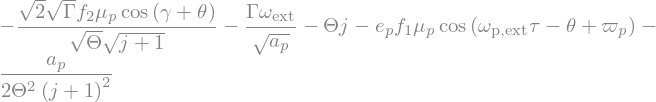

In [6]:
H = to_canonical(calH)
th, Th = symbols("theta Theta")
genFunc = Th * ((j + 1) * l - j * tau)
coords_thTh, H1 = F2_canTran(H, genFunc, [l], [Th], [th], [L], tau)
H1 = H1.simplify()
display(H1)

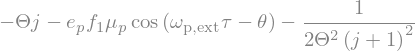

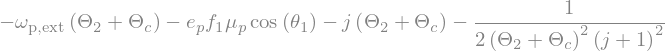

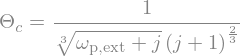

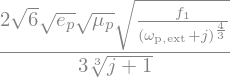

In [7]:
Hcer = H1.subs({f2:0,a_p:1,om:0,pom_p:0})
display(Hcer)
Th1, th1 = symbols("Theta_1 theta_1")
S1 = Th1*(th-om_p*tau)
display(Eq(th,solve(th1-S1.diff(Th1),th)[0]))
display(Eq(Th,S1.diff(th)))
Hcer = Hcer.subs({Th:Th1,th:solve(th1-S1.diff(Th1),th)[0]}) + S1.diff(tau)

Th2, th2, Thc = symbols("Theta_2 theta_2 Theta_c")
S2 = th1*(Th2+Thc)
display(S2)
display(Eq(th1, solve(th2-S2.diff(Th2),th1)[0] ))
Th2_expr = solve(Th1-S2.diff(th1),Th2)[0]
display(Eq(Th2, Th2_expr ))

Hcer=Hcer.subs({Th1:solve(Th1-S2.diff(th1),Th1)[0]})
display(Hcer)
#
Thc_expr = 1/(j+om_p)**Rational(1,3)/(j+1)**Rational(2,3)
display(Eq(Thc,Thc_expr))
display(Hcer.diff(Th2).subs(Th2,0).subs(Thc,Thc_expr))
#
Hcer0 = Hcer.taylor_term(0,Th2) + Hcer.taylor_term(1,Th2) + Hcer.taylor_term(2,Th2)
Hcer0 = Hcer0-Hcer0.args[1]-Hcer0.args[2]-Hcer0.args[3]
Hcer0 = Hcer0.subs(Thc,Thc_expr)
#Hcer0 = Hcer0 #- Hcer0.args[0]- Hcer0.args[1]- Hcer0.args[2]
WTh2 = 2*solve(Hcer0.subs(th1,pi),Th2)[1]
display(WTh2)

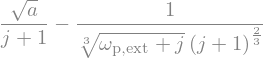

In [8]:
Th2_expr.subs(Th1,Th).subs(Th,coords_thTh[Th].subs(L,sqrt(a))).subs(Thc,Thc_expr)

# LER

In [9]:
f1val_outside

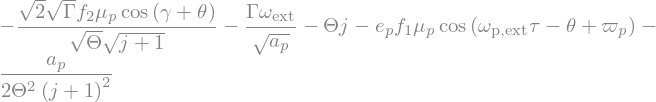

In [10]:
H = to_canonical(calH)
th, Th = symbols("theta Theta")
genFunc = Th * ((j + 1) * l - j * tau)
coords_thTh, H1 = F2_canTran(H, genFunc, [l], [Th], [th], [L], tau)
H1 = H1.simplify()
display(H1)

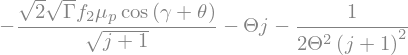

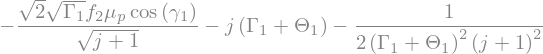

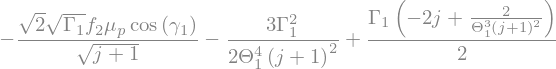

- \frac{\sqrt{2} \sqrt{\Gamma_{1}} f_{2} \mu_{p} \cos{\left(\gamma_{1} \right)}}{\sqrt{j + 1}} - \frac{3 \Gamma_{1}^{2}}{2 \Theta_{1}^{4} \left(j + 1\right)^{2}} + \frac{\Gamma_{1} \left(- 2 j + \frac{2}{\Theta_{1}^{3} \left(j + 1\right)^{2}}\right)}{2}


In [11]:
Hler = H1.subs({f1:0,a_p:1,om:0,pom_p:0,f2:f2*sqrt(Th)})
display(Hler)

G1, g1 = symbols("Gamma_1 gamma_1")
S1 = G1 * (th + g) + Th1 * th
display(S1)
th_expr = solve(th1 - S1.diff(Th1), th)[0]
display(Eq(th, th_expr))
Th1_expr = solve(Th - S1.diff(th), Th1)[0]
display(Eq(Th1, Th1_expr))
Th_expr = S1.diff(th)
display(Eq(Th, Th_expr))
G_expr = S1.diff(g)
display(Eq(G, G_expr))

g_expr = solve(g1 - S1.diff(G1), g)[0]
display(Eq(g, g_expr))
G1_expr = solve(G - S1.diff(g), G1)[0]
display(Eq(G1, G1_expr))

Hler = Hler.subs({g: g_expr, Th: Th_expr, G: G_expr})


display(Hler)

display(Hler.taylor_term(3, sqrt(G1)))
Hler = (
    #Hler.taylor_term(0, sqrt(G1))
     Hler.taylor_term(1, sqrt(G1))
    + Hler.taylor_term(2, sqrt(G1))
    + Hler.taylor_term(3, sqrt(G1))
    + Hler.taylor_term(4, sqrt(G1))
)

display(Hler)
print(latex(Hler))


#X, Y = symbols("X,Y")
#Hler = Hler.subs({G1:Rational(1,2)*(X**2+Y**2)})
#
#display(Hler.diff(Y).subs({X:0}))

# Hamiltonian

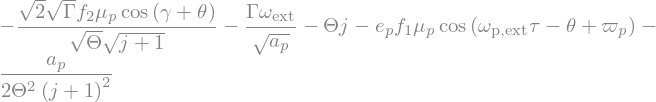

In [12]:
H = to_canonical(calH)
th, Th = symbols("theta Theta")
genFunc = Th * ((j + 1) * l - j * tau)
coords_thTh, H1 = F2_canTran(H, genFunc, [l], [Th], [th], [L], tau)
H1 = H1.simplify()
display(H1)

In [13]:
X, Y = symbols("X Y")
PB = PoissonBracket([g], [G])
X_gG = sqrt(2*G)*sin(g)
Y_gG = sqrt(2*G)*cos(g)
# PB(momentum,coordinate) = 1, 0 otherwise
display(PB(Y_gG, X_gG).simplify())
#sol =  solve([X-X_gG,Y-Y_gG],[g, G])
#g_XY = sol[0][0]
#G_XY = sol[0][1]
g_XY = atan2(X,Y)
G_XY = Rational(1,2)*(X**2+Y**2)
display(Eq(X,X_gG))
display(Eq(Y,Y_gG))

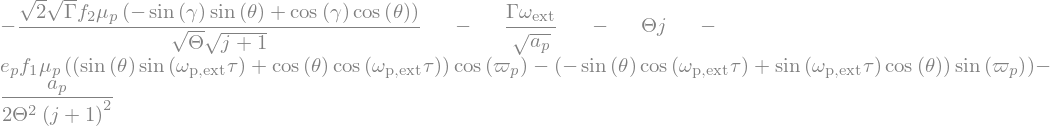

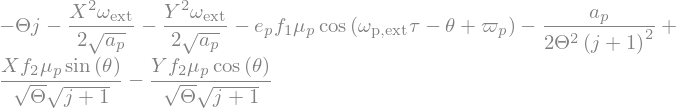

In [14]:
H2 = expand_trig(H1)
display(H2)
H_XYthTh = H2.subs(
    {
        sin(g): X / sqrt(2 * G),
        cos(g): Y / sqrt(2 * G),
        G: Rational(1, 2) * (X**2 + Y**2),
    }
).simplify()
display(H_XYthTh)

# Conserved Quantities

In [15]:
Hcons = H1.subs({f1:0,a_p:1,om:0})
K_1, K_2, k_1, k_2 = symbols("K_1 K_2 k_1 k_2")
genFunc1 = K_1*(th+g) + K_2*th
genFunc1

In [16]:
genFunc1.diff(g)

In [17]:
genFunc1.diff(th)

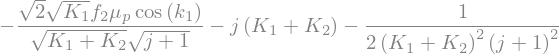

In [18]:
Hcons.subs(Th,genFunc1.diff(th)).subs(G,genFunc1.diff(g)).subs(g,k_1-th)

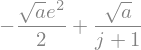

In [19]:
K2_expr = (Th-G).subs({G:Rational(1,2)*sqrt(a)*e**2,Th:sqrt(a)/(j+1)})
K2_expr

# Dissipation

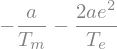

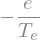

In [20]:
adot_dis = -a/Tm - 2*a*e**2/Te
edot_dis = -e/Te
display(adot_dis,edot_dis)

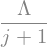

In [21]:
coords_thTh[Th]

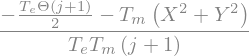

In [22]:
Thdot_dis = to_canonical(to_orbelts(coords_thTh[Th]).diff(a)*adot_dis).subs({G: G_XY, L: coords_thTh[L]}).simplify()
display(Thdot_dis)

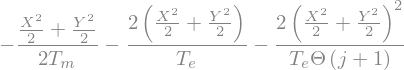

In [23]:
Gdot_dis = (
    to_canonical(
        (
            (Rational(1, 2) * sqrt(a) * e**2).diff(e) * (edot_dis)
            + (Rational(1, 2) * sqrt(a) * e**2).diff(a) * (adot_dis)
        ).simplify()
    )
    .simplify()
    .subs({G: G_XY, L: coords_thTh[L]})
)

display(Gdot_dis)

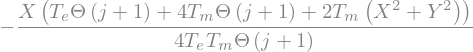

In [24]:
Xdot_dis = (X_gG.diff(G) * Gdot_dis).subs(
    {
        sin(g): X / sqrt(2 * G),
        cos(g): Y / sqrt(2 * G),
        G: Rational(1, 2) * (X**2 + Y**2),
    }
).simplify()
Xdot_dis

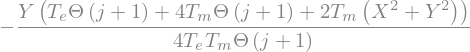

In [25]:
Ydot_dis = (Y_gG.diff(G) * Gdot_dis).subs(
    {
        sin(g): X / sqrt(2 * G),
        cos(g): Y / sqrt(2 * G),
        G: Rational(1, 2) * (X**2 + Y**2),
    }
).simplify()
Ydot_dis

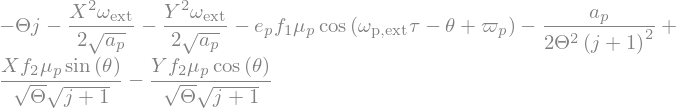

In [26]:
H_XYthTh

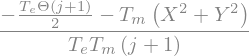

In [27]:
Thdot_dis

In [28]:
Pv = sqrt(1.31037069710445)/3
H = 1/2/Pv**2/9 - Pv*2
print(H)
print(-0.1*f1val_outside*1e-3/(-1/9/Pv**2 - 2)*6)

-0.381571414184445
-0.000335603535758360


In [29]:
1.31037069710445+0.000439765039102399

In [30]:
print(latex(H_XYthTh))

- \Theta j - \frac{X^{2} \omega_{\rm{ext}}}{2 \sqrt{a_{p}}} - \frac{Y^{2} \omega_{\rm{ext}}}{2 \sqrt{a_{p}}} - e_{p} f_{1} \mu_{p} \cos{\left(\omega_{\rm{p,ext}} \tau - \theta + \varpi_{p} \right)} - \frac{a_{p}}{2 \Theta^{2} \left(j + 1\right)^{2}} + \frac{X f_{2} \mu_{p} \sin{\left(\theta \right)}}{\sqrt{\Theta} \sqrt{j + 1}} - \frac{Y f_{2} \mu_{p} \cos{\left(\theta \right)}}{\sqrt{\Theta} \sqrt{j + 1}}


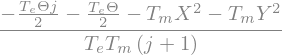

In [31]:
Thdot_dis.expand().cancel().simplify(deep=True)

# Integration functions

In [32]:
def orb_elts_from_integration(integration):
    y = integration.y
    X_vals = y[0, :].astype(float)
    Y_vals = y[1, :].astype(float)
    th_vals = y[2, :].astype(float) % (2 * np.pi)
    th_vals = th_vals - 2 * np.pi * (th_vals > np.pi)
    Th_vals = y[3, :].astype(float)
    g_func = lambdify([X, Y], g_XY)
    G_func = lambdify([X, Y], G_XY)
    a_func = lambdify(Th, a_Th)
    g_vals = g_func(X_vals, Y_vals)
    G_vals = G_func(X_vals, Y_vals)
    a_vals = a_func(Th_vals)
    return (
        integration.t,
        -g_vals,
        np.sqrt(2 * G_vals / np.sqrt(a_vals)),
        a_vals,
        th_vals,
    )


def plugin(expr, params):
    return expr.subs(params).evalf()

In [33]:
def run(mupval, ompval, omval, epval, events, apfunc):
    Xdot_prec = Xdot.subs({mu_p:mupval, om: omval, om_p: ompval, e_p: epval})
    Ydot_prec = Ydot.subs({mu_p:mupval, om: omval, om_p: ompval, e_p: epval})
    thdot_prec = thdot.subs({mu_p:mupval, om: omval, om_p: ompval, e_p: epval})
    Thdot_prec = Thdot.subs({mu_p:mupval, om: omval, om_p: ompval, e_p: epval})

    lhs = lambdify(
        [a_p, tau, X, Y, th, Th], [Xdot_prec, Ydot_prec, thdot_prec, Thdot_prec]
    )

    def LHS(t, Y):
        return lhs(apfunc(t), t, *Y)

    integration = sp.integrate.solve_ivp(
        LHS,
        tspan,
        initVals,
        # atol=1e-9,
        rtol=1e-9,
        t_eval=t_eval,
        events=events,
        method="DOP853",
    )
    return integration

In [34]:
def solve_ivp(params):
    ind, mupval, ompval, omval, epval, events, apfunc = params[0], params[1], params[2], params[3], params[4], params[5], params[6]
    print(ind)
    sol = run(mupval, ompval, omval, epval, events, apfunc)
    t_int, pom_int, e_int, a_int, th_int = orb_elts_from_integration(sol)
    data = {}
    data["t"] = t_int
    data["pom"] = pom_int
    data["e"] = e_int
    data["a"] = a_int
    data["th"] = th_int
    occurances = sol.t_events
    return (data, params, occurances)